# BMI for Age

When parents bring their kids to the pediatrician, one of the most important checks is to have the childs heigh, weight, and BMI plotted on growth charts to understand their development. The charts, a screen of which appears below, are ubiquitious. 

![bmichart](MaleBMI2-20.png)

Sure enough, many many EHRs automatically show the graph and the patient's position on the chart right there making it easy for physicians and patients to review. They included automated features to measure growth velocity etc. However while the EHR stores the BMI, height, and weight measurements, Most systems do not store the comparative measure of those values for the child's age. This leaves analysts and data scientists in a tricky position when it comes to estimating obesity. How do we identify children who may be obese absent this information? 

In meetings just last week, a reporting team was lamenting the lack of obesity related ICD codes for pediatrics in their population and lamenting that they could not pull BMI for age percentile from their EPIC EHR system. This is no slight against the EHRs. These calculations are calculated based on outside references (provided by the WHO or CDC) they are intrepretations and aren't on their own a vital sign or part of the record. 

In this post, we are going to calculate the BMI percentiles for 2000 sample patients. The patient population is a synthetic population of 2,026 pediatric patients (aged 0-20 years) created using the amazing [Synthea](https://syntheticmass.mitre.org/) tool. So we will be reading these patient's charts in the form of FHIR documents directly. In the process we will do the following: 

1. Identify each patient's most recent BMI and their age in months on the date that BMI was taken. We will do this using a synthetic population of FHIR files. 
2. Use the CDC's reference tables to identify the nearest percentile for that patient's measurement from the previous step. 
3. Create a population level chart that shows 

Let's start by setting up libraries we will need. 

In [160]:
import json
import fhirclient.models.bundle as b
import fhirclient.models.patient as p
import fhirclient.models.observation as o
from pathlib import Path
from decimal import *
calculator = Calculator(adjust_height_data=False, adjust_weight_scores=False,
                       include_cdc=True ,logger_name='pygrowup',
                       log_level='INFO')
import pandas as pd
import matplotlib
from datetime import date, timedelta, datetime
import csv
import altair as alt
import numpy as np
import seaborn as sns
alt.renderers.enable('notebook')

%matplotlib inline

We have posted a zip file of the [2,026 FHIR](https://s3.amazonaws.com/algorex-working-data/pediatric-fhir-data/fhir.zip) patient bundles that you can use to run this notebook. Unzip the file to the data/directory to continue. 

Below, we will verify that you have some FHIR files to run. 

In [194]:
p = Path('data/fhir')
files_to_load = [f for f in p.glob('*.json')]

if len(files_to_load) == 0:
    raise StopIteration("You don't have any FHIR files")
else:
    print("Loading {0} FHIR Files".format(len(files_to_load)))

Loading 2026 FHIR Files


We will also load as constants the CDC data tables that contain the percentile values for BMI at various ages. 

In [195]:
def getBMITable(sex):
    if sex == 'M':
        file = 'data/male-2-20.csv'
    elif sex == 'F':
        file = 'data/female-2-20.csv'
    with open(file, 'r', encoding='utf-8-sig') as csvfile:
        reader = csv.DictReader(csvfile, quoting=csv.QUOTE_NONNUMERIC, fieldnames=['AgeMonths',3,5,10,25,50,75,85,90,95,97])
        bmi_table = [row for row in reader]
    return bmi_table

MALE_BMI_TABLE = getBMITable('M')
FEMALE_BMI_TABLE = getBMITable('F')
   

The functions below uses the [SMART Python FHIR Client](http://docs.smarthealthit.org/clients/python/) to parse the FHIR bundles and obtain the elements we will need: 

* the patients date of birth
* their sex
* all of their BMI observations and the values 

In [196]:
def getBMIObeservation(entry):
    if entry.resource.resource_type == 'Observation' and entry.resource.code.coding[0].code == '39156-5':
        return (entry.resource.effectiveDateTime.date, entry.resource.valueQuantity.value)
    else:
        return None

def getDateOfBirth(entry):
    if entry.resource.resource_type == 'Patient':
        return entry.resource.birthDate.date
    
def getSex(entry):
    if entry.resource.resource_type == 'Patient':
        return entry.resource.gender
    
def getAgeMonths(dob, visitdate):
    age_in_months = (visitdate.date()-dob)/timedelta(days=30.0)
    return age_in_months
        

Now we will tie all of this together as follows: 


In [199]:
def getLatestBMI(bundle):
    # Find any obersvations with a BMI
    possible_visits_with_bmis = [getBMIObeservation(entry) for entry  in bundle.entry if getBMIObeservation(entry) ]
    if possible_visits_with_bmis:
        visit_date, bmi = max(possible_visits_with_bmis, key=lambda x:x[0]) # Get us the latest BMI
    else:
        return None #no possible BMIs 
    #Everyone's birthdate should be same but there is a possibility that this is notated several times in a FHIR bundle
    birthDate = max([getDateOfBirth(entry) for entry in bundle.entry if getDateOfBirth(entry) ])
    age = getAgeMonths(birthDate, visit_date) #uses the visit date from above
    if 24.0 < age > 240.0:
        return None #patients older than 20 and below 2 don't need  this measurementt
    sex = max([getSex(entry) for entry in bundle.entry if getGender(entry) ])
    if sex == 'male':
        bmi_table = MALE_BMI_TABLE
    else:
        bmi_table = FEMALE_BMI_TABLE
    
    age_row = min([row["AgeMonths"] for row in bmi_table if row["AgeMonths"] > age ])
    #Get their BMI from the CDC tables
    bmi_pct_row_values = ([row for row in bmi_table if row['AgeMonths'] == age_row][0]).copy()
    bmi_pct_row_values.pop('AgeMonths')
    bmi_pct_row_values[100] = 100 #this is the maximum case 
    pct = min([percentile for (percentile, bmi_value) in bmi_pct_row_values.items() if bmi <= bmi_value])
    
    
    return {'ageMonths':int(age),'BMI':bmi, 'BMIpct':pct, 'sex':sex}
    

Now for each file we have, we will run the functions we defined and save the results. This can take up to 2 minutes for all the files 

In [200]:

bmi_results = []

for f_json in files_to_load:

    try:
        with open(f_json, 'r') as jsonfile:
            json_results = json.load(jsonfile)
    except:
        continue
    bundle = b.Bundle(json_results) 
    result = getLatestBMI(bundle)
    if result:
        bmi_results.append(result)

In [84]:
len(bmi_results)

866

In [140]:
df = pd.DataFrame(bmi_results)
df.dtypes
df['ageYears'] = (df.ageMonths/12).astype(int)

In [142]:
# data_to_plot = df.sort_values('ageMonths').groupby(['ageMonths', 'sex']).agg({'BMI':np.mean, 'BMIpct':np.median})
data_to_plot = df.sort_values('ageMonths').reset_index()

We can use [seaborn](https://seaborn.pydata.org/tutorial/regression.html) to see how our population looks. The seaborn charts below plot the observed BMIs at the 10th, 25th, 50th, 75th, and 90th percentile. You can see the fitted polynomial regressions (which are smooth lines) start to appear a lot like the CDC growth chart. 

/Users/luke/Projects/bmi-fhir/venv/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(20, 250)

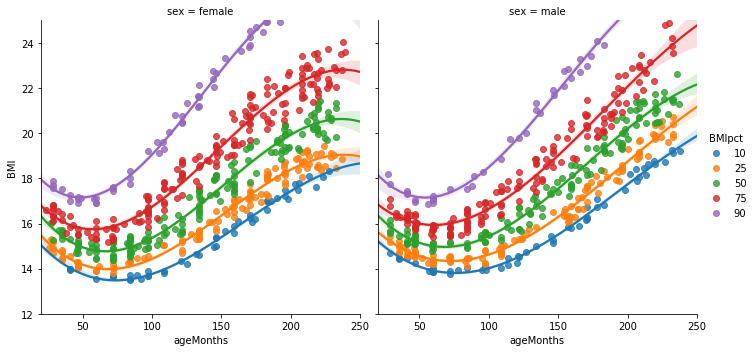

In [202]:
lm = sns.lmplot(data=data_to_plot[(data_to_plot.BMIpct.isin((10,25,50,75,90)) )], 
           x='ageMonths', y='BMI', hue='BMIpct', col='sex', order=3)

axes = lm.axes
axes[0,0].set_ylim(12,25)
axes[0,1].set_ylim(12,25)

axes[0,0].set_xlim(20,250)
axes[0,1].set_xlim(20,250)

Lastly, we can view our population averages across both sexes. 

/Users/luke/Projects/bmi-fhir/venv/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


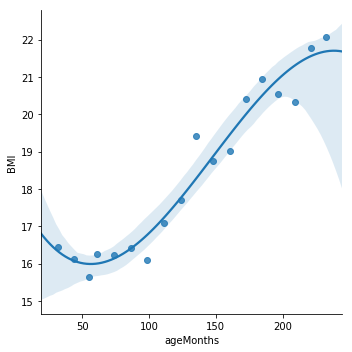

In [203]:
sns.lmplot(data=agg_data_to_plot, x='ageMonths', y='BMI', order=3)